# Matter-Antimatter asymmetries at the LHC

## Example program

Author: Dr Marco Gersabeck

Copyright &copy; 2020-23 The University of Manchester

### Overview
This example code follows the structure described in the lab script and depicted in the scheme below.

<img src="LabScheme.png" width="600">

In [16]:
!pip uninstall numpy -y
!pip install numpy==1.22.0

  Using cached numpy-1.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Configuration
The cell below imports all required Python modules. If you need more and add them there, make sure to execute this cell again before executing the cell requiring the new module.

In [1]:
import uproot
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
from tqdm import tqdm

In [3]:
from sklearn.cluster import KMeans


### Input data
This opens input data files and assigns them to variables.

In [2]:
path = './data/' # set this to '' to run on the GitHub version
events_sim = uproot.open(path+'PhaseSpaceSimulation.root')
events_down = uproot.open(path+'B2HHH_MagnetDown.root')
events_up = uproot.open(path+'B2HHH_MagnetUp.root')

### Select data and calculate derived quantities
The following cell reads the input data. This is where all derived quantities (such as transverse momentum) should be calculated and where selection criteria are applied (such as the z component of the momentum being positive).

In [4]:
from src.invariant_mass import find_invariant_mass

In [4]:
# def find_invariant_mass_simulation(momentum_1=[0, 0, 0],
#                                    momentum_2=[0, 0, 0],
#                                    momentum_3=[0, 0, 0],
#                                    mass_array=[493.677, 493.677, 493.677]):
    
#         p1_x, p1_y, p1_z = momentum_1
#         p2_x, p2_y, p2_z = momentum_2
#         p3_x, p3_y, p3_z = momentum_3
    
#         E1 = np.sqrt(np.square(p1_x) + np.square(p1_y) + np.square(p1_z) + np.square(mass_array[0]))
#         E2 = np.sqrt(np.square(p2_x) + np.square(p2_y) + np.square(p2_z) + np.square(mass_array[1]))
#         E3 = np.sqrt(np.square(p3_x) + np.square(p3_y) + np.square(p3_z) + np.square(mass_array[2]))
        
#         energy_squared   = np.square(E1 + E2 + E3)
#         total_momentum_x = p1_x + p2_y + p3_z
#         total_momentum_y = p1_x + p2_y + p3_z
#         total_momenum_z  = p3_x + p3_y + p3_z
#         #total momentum
#         inv_mass_squared = energy_squared - np.square(
#             total_momentum_x) - np.square(total_momentum_y) - np.square(total_momenum_z)

#         return np.sqrt(inv_mass_squared)

In [60]:
# list_of_interesting_keys = []
# for i in range(1, 4):
#     exec(f"list_of_interesting_keys.append('H{i}_PX')")
#     exec(f"list_of_interesting_keys.append('H{i}_PY')  ")
#     exec(f"list_of_interesting_keys.append('H{i}_PZ')  ")
#     exec(f"list_of_interesting_keys.append('H{i}_Charge')  ")
#     exec(f"list_of_interesting_keys.append('H{i}_ProbK')  ")
#     exec(f"list_of_interesting_keys.append('H{i}_ProbPi')  ")
#     exec(f"list_of_interesting_keys.append('H{i}_isMuon')  ")


# def read_file(path_name="", MAX_EVENTS=1000, mode=1, keys = list_of_interesting_keys,
#               selection=False):

#     if not path_name:
#         path = 'data/'  # set this to '' to run on the GitHub version
#     else:
#         path = path_name

#     #temporarily 
#     event_counter = 0

#     pX = []
#     pY = []
#     pZ = []
#     pT = []


#     h1_probpi = []
#     h1_probk = []

#     h2_probpi = []
#     h2_probk = []

#     h3_probpi = []
#     h3_probk = []

#     master_probpi = []
#     master_probk = []

#     invariant_mass_array = []



#     print("Input data varaiables: ")
#     if mode == 0:
#         events_test = uproot.open(path+'example_file.root')
#         print("Test mode")
#         trees = [events_test['PhaseSpaceTree;1']]  # Test mode
# #        return [[0], [0], [0], [0]]
#         print(events_test.keys())

#     elif mode == 1:
#         events_sim = uproot.open(path+'PhaseSpaceSimulation.root')
#         trees = [events_sim['PhaseSpaceTree']]                       # Simulation
#         print("Phase space simulation")
#         print(events_sim.keys())
#     elif mode == 2:
#         # Magnet down data
#         events_down = uproot.open(path+'B2HHH_MagnetDown.root')
#         trees = [events_down['DecayTree']]
#         print("Magnet down data")
#         print(events_down.keys())
#     elif mode == 3:
#         # Magnet up data
#         events_up = uproot.open(path+'B2HHH_MagnetUp.root')
#         trees = [events_up['DecayTree']]
#         print("Magnet up data")
#         print(events_up.keys())
#     elif mode == 4:
#         trees = [events_down['DecayTree'], events_up['DecayTree']]
#         print("Magnet up and down data")
#         print(events_down.keys())
#     else:
#         print("Mode not recognised")
#         return [[0], [0], [0], [0]]
#     print("Varialbes read")
#     print()
#     for tree in trees:
#         # This outer loop is a technical loop of uproot over chunks of events
#         for data in tree.iterate(keys):
#             # As Python can handle calculations with arrays, we can calculate derived quantities here
#             pT_H1 = np.sqrt(data['H1_PX']**2+data['H1_PY']**2)
#             pT_H2 = np.sqrt(data['H2_PX']**2+data['H2_PY']**2)
#             pT_H3 = np.sqrt(data['H3_PX']**2+data['H3_PY']**2)

#             p1_array = [data['H1_PX'], data['H1_PY'], data['H1_PZ']]
#             p2_array = [data['H2_PX'], data['H2_PY'], data['H2_PZ']]
#             p3_array = [data['H3_PX'], data['H3_PY'], data['H3_PZ']]

#             # Your invariant mass calculation should go here
#             inv_mass = find_invariant_mass(p1_array, p2_array, p3_array)
#             invariant_mass_array.append(inv_mass)
#             #invariant_mass_array.append(0)





#             # This loop will go over individual events
#             for i in tqdm(range(0, len(data['H1_PZ']))):
#                 event_counter += 1
#                 if 0 < MAX_EVENTS and MAX_EVENTS < event_counter:
#                     break
#                 if 0 == (event_counter % 100000):
#                     print('Read', event_counter, 'events')
#                 # Decide here which events to analyse
#                 if (data['H1_PZ'][i] < 0) or (data['H2_PZ'][i] < 0) or (data['H3_PZ'][i] < 0):
#                     continue


#                 if selection:
#                     probabilities_itr = [[data['H1_ProbK'][i], data['H1_ProbPi'][i]],
#                                         [data['H2_ProbK'][i], data['H2_ProbPi'][i]],
#                                         [data['H3_ProbK'][i], data['H3_ProbPi'][i]]]
#                     charges_itr = [data['H1_Charge'][i], data['H2_Charge'][i], data['H3_Charge'][i]]
#                     muon_prob = [data['H1_isMuon'][i], data['H2_isMuon'][i], data['H3_isMuon'][i]]
                
#                     #check if any of the muon_prob is 1
#                     if any(muon_prob):
#                         continue

#                     if selection_rule_iterator(probabilities_itr, charges_itr) is False:
#                         continue

#                     if assign_kaon_iterator(probabilities_itr, charges_itr) is False:
#                         continue

                
#                 # Fill arrays of events to be plotted and analysed further below
#                 # Adding values for all three hadrons to the same variable here
#                 pT.append(pT_H1[i])
#                 pT.append(pT_H2[i])
#                 pT.append(pT_H3[i])
#                 pX.append(data['H1_PX'][i])
#                 pX.append(data['H2_PX'][i])
#                 pX.append(data['H3_PX'][i])
#                 pY.append(data['H1_PY'][i])
#                 pY.append(data['H2_PY'][i])
#                 pY.append(data['H3_PY'][i])
#                 pZ.append(data['H1_PZ'][i])
#                 pZ.append(data['H2_PZ'][i])
#                 pZ.append(data['H3_PZ'][i])

#                 #
#                 h1_probpi.append(data['H1_ProbPi'][i])
#                 h1_probk.append(data['H1_ProbK'][i])
#                 h2_probpi.append(data['H2_ProbPi'][i])
#                 h2_probk.append(data['H2_ProbK'][i])
#                 h3_probpi.append(data['H3_ProbPi'][i])
#                 h3_probk.append(data['H3_ProbK'][i])
                
#                 ##
#                 master_probpi.append(data['H1_ProbPi'][i])
#                 master_probk.append(data['H1_ProbK'][i])
#                 master_probpi.append(data['H2_ProbPi'][i])
#                 master_probk.append(data['H2_ProbK'][i])
#                 master_probpi.append(data['H3_ProbPi'][i])
#                 master_probk.append(data['H3_ProbK'][i])

#     print(f"Read {event_counter:d} events")

#     return [pT, pX, pY, pZ, (h1_probpi, h1_probk), (h2_probpi, h2_probk), (h3_probpi, h3_probk), (master_probpi, master_probk), invariant_mass_array]
pT, pX, pY, pZ, (h1_probpi, h1_probk), (h2_probpi, h2_probk), (h3_probpi, h3_probk), (master_probpi, master_probk), invariant_mass_array = read_file(mode=1,
#                                                                                                                                                      MAX_EVENTS=100)


IndentationError: unexpected indent (1932741356.py, line 164)

In [14]:
from src.file_reading import read_file

pT, pX, pY, pZ, (h1_probpi, h1_probk), (h2_probpi, h2_probk), (h3_probpi, h3_probk), (master_probpi, master_probk), invariant_mass_array = read_file(mode=2, 
                                                                                                                                                     MAX_EVENTS=100000,
                                                                                                                                                     selection=True)


Input data varaiables: 
Magnet down data
['DecayTree;1']
Varialbes read



100%|██████████| 100000/100000 [01:20<00:00, 1248.60it/s]


Read 100000 events


  0%|          | 0/100000 [00:00<?, ?it/s]

Read 100004 events


### Visualise data
The cell below produces histograms of the data contained in the arrays that were filled in the cell above.

Plotting 1D histogram
Plotting 2D histogram


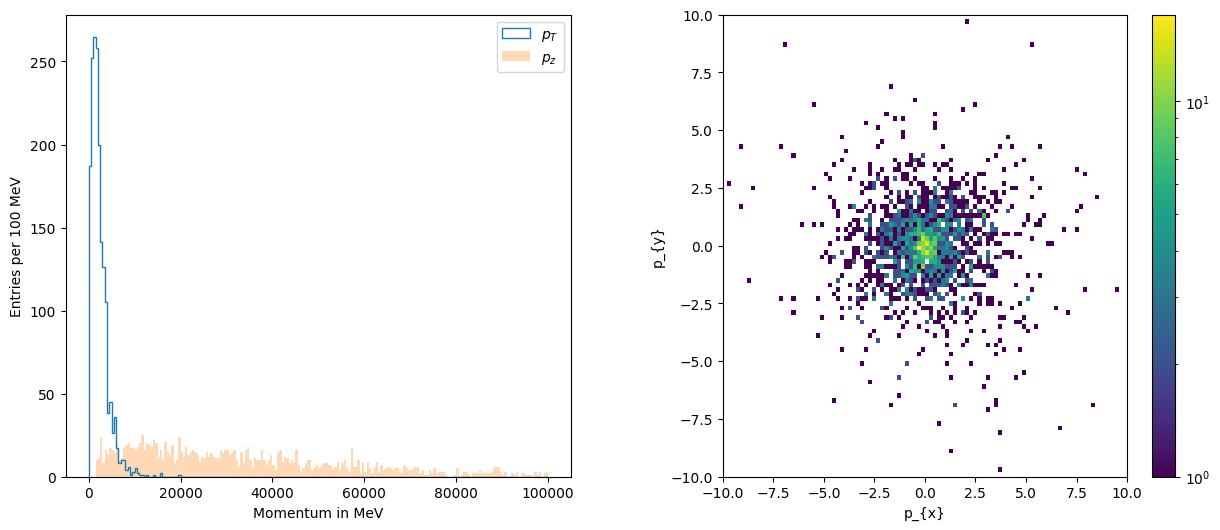

In [6]:
# Plot some histograms -- NOTE: this can take several minutes

# This line produces two plots side-by-side. 
# It's still useful just for one plot as you can set the size and get the fig,ax objects
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

# This plots two 1D-histograms.
# The color is changed automatically, the styles are set by hand
# keep hold of the pT histogram data for fitting later
print('Plotting 1D histogram')
values_pT,bins_pT,patches_pT = ax[0].hist(pT, bins = 200, range = [0, 100000],histtype='step',label='$p_{T}$')
ax[0].hist(pZ, bins = 200, range = [0, 100000],histtype='stepfilled',alpha=0.3,label='$p_{z}$')
ax[0].set_xlabel('Momentum in MeV')
ax[0].set_ylabel('Entries per 100 MeV')
ax[0].legend()
plt.savefig('pTpZ.pdf')

# This plots a 2D-histogram with values converted to GeV and with a logarithmic colour scale
print('Plotting 2D histogram')
h2d = ax[1].hist2d(np.true_divide(pX,1000), np.divide(pY,1000), bins = [100,100], range = [[-10,10],[-10,10]],norm=colors.LogNorm())
ax[1].set_xlabel('p_{x}')
ax[1].set_ylabel('p_{y}')
fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
plt.savefig('pXpY.pdf')

Plotting 1D histogram
Plotting 2D histogram


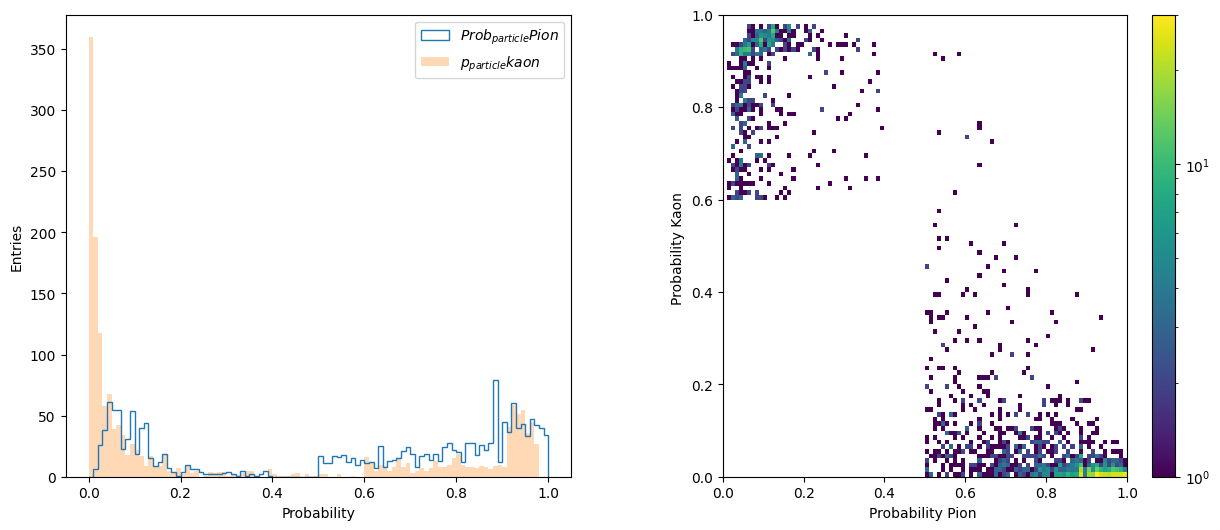

In [8]:
def plotting_histograms_probability(particle=None):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots
    print('Plotting 1D histogram')
    if particle == 1:
        interest_pi = h1_probpi
        interest_k  = h1_probk
    if particle == 2:
        interest_pi = h2_probpi
        interest_k  = h2_probk
    if particle == 3:
        interest_pi = h3_probpi
        interest_k = h3_probk
        
    else:
        interest_pi = master_probpi
        interest_k = master_probk
    values_probpi, bins_probpi, patches_probpi = ax[0].hist(interest_pi, bins=100, range=[0,1], histtype='step', 
                                                             label='$Prob_{particle} Pion$')
    ax[0].hist(interest_k, bins = 100, range = [0, 1],histtype='stepfilled',alpha=0.3,label='$p_{particle} kaon$')
    ax[0].set_xlabel('Probability')
    ax[0].set_ylabel('Entries')
    ax[0].legend()
    #plt.savefig(f"Prob Pion vs Kaon Histogram particle{particle}")
    #plt.savefig(f"Prob_kaon_pion_{particle}.pdf")
    
    print('Plotting 2D histogram')
    h2d = ax[1].hist2d(interest_pi, interest_k,
                       bins = [100,100], range = [[0,1],[0,1]],norm=colors.LogNorm())
    ax[1].set_xlabel(f'Probability Pion ')
    ax[1].set_ylabel(f'Probability Kaon ')
    fig.colorbar(h2d[3],ax=ax[1]) # let's add the colour scale
    #plt.savefig(f"Prob_pi_prob_k_{particle}_2d.pdf")
    return values_probpi, bins_probpi, patches_probpi

values_probpi, bins_probpi, patches_probpi = plotting_histograms_probability(particle=
                                                                            None)
    

Plotting 1D histogram
Plotting 2D histogram


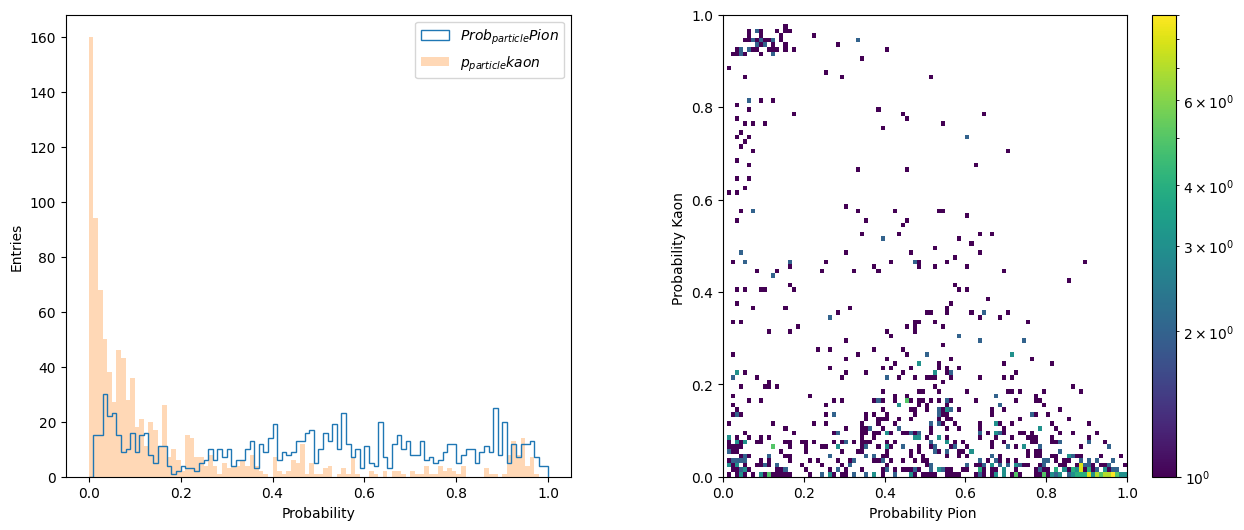

In [11]:
plotting_histograms_probability(3)

In [16]:
print(np.shape(pY))
print(np.shape(h1_probk))
print(np.shape(data[b'H1_ProbPi']))


(3000,)
(1000,)
(44583,)


## Clustering using SKLEARN

In [15]:
print(np.shape(master_probpi))
print(np.shape(master_probk))

master_probpi = np.array(master_probpi).flatten()
master_probk  = np.array(master_probk).flatten()
master_probpi = np.expand_dims(master_probpi, axis=1)
master_probk  = np.expand_dims(master_probk, axis=1)

master_probability = np.concatenate((master_probpi, master_probk), axis=1)
print(np.shape(master_probability))
print(master_probability[0:10])

(30000, 1)
(30000, 1)
(30000, 2)
[[8.88755083e-01 3.86155248e-02]
 [9.57603753e-02 3.07541102e-01]
 [1.38845146e-01 1.93003953e-01]
 [3.90639901e-02 7.35562444e-02]
 [1.37436718e-01 4.84067202e-02]
 [7.58603454e-01 8.03965032e-02]
 [6.36692822e-01 3.00945342e-02]
 [9.86190617e-01 7.98135996e-04]
 [3.99601638e-01 7.50750899e-01]
 [3.50968808e-01 2.11413682e-01]]


In [7]:
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": [1,2,3,4,5,6],
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(master_probability)

NameError: name 'master_probability' is not defined

In [28]:
import pandas as pd

df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

,Number of components,Type of covariance,BIC score
23,6,full,-1325.787143
17,6,diag,-1301.722993
16,5,diag,-1288.613113
22,5,full,-1256.068693
21,4,full,-1142.027535


/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


<Axes: >

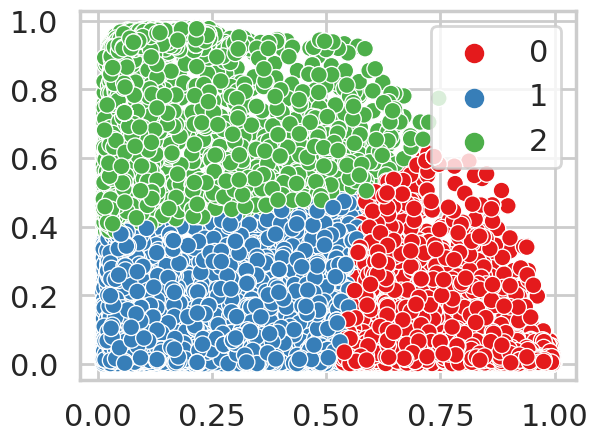

In [29]:
# fit a kmeans clustering model to the data
kmeans = KMeans(n_clusters=3, random_state=0).fit(master_probability)
#plot the clusters

# SEABORN PLOT OF THE CLUSTERS
import seaborn as sns

# plot the clusters using seaborn 
sns.scatterplot(x=master_probability[:,0], y=master_probability[:,1], hue=kmeans.labels_, palette='Set1')

<Axes: >

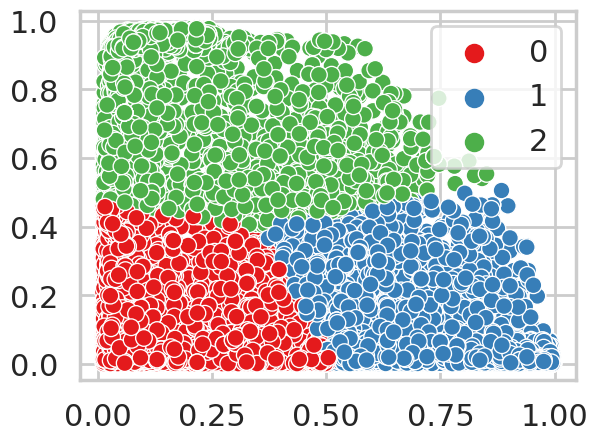

Bad pipe message: %s [b"Z\x8b+\xc6AG6\x9dM\xba\xec\xbcz\x02d\x0f\xd0\x98 |\x7f,\x9b\xd1R\xfac\xe8\x9b\xbf\xb4\xc0\xc6\xb3\x97\x9dv{\x14\xe7\x19'i\x96\xcc\x17\x87\x07\x82\xe5\x82\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00"]
Bad pipe message: %s [b'\xd9\x0c\xe2#\xb92\xb3T4\xb6\xf9p\xca\x97\xab\xe0Tu \xb01{N\xd0\xa9\x17\xd6\x1b}\xcam\x10~\xca\xed0\r\xdf}h\xf4P\x02\x0c\xb0\xcf\xd3\xe6\xce\xe8\xab\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07']
Bad pipe message: %s [b"n\xb7!\xc6\\p\xedB\xd1B\xae5ol\x875a\xfd\x00\x00|\xc0,\xc00\x00\xa3\x00\x9f\xcc\xa9\xcc\xa8\xcc\xaa\xc0\xaf\xc0\xad

In [31]:
#fit a GMM model to the data using EM algorithm#
gmm = GaussianMixture(n_components=3, covariance_type='tied').fit(master_probability)
#plot the clusters
sns.scatterplot(x=master_probability[:,0], y=master_probability[:,1], hue=gmm.predict(master_probability), palette='Set1')
#plt.scatter(master_probability[:,0], master_probability[:,1], c=gmm.predict(master_probability), cmap='rainbow')

## Finding Invariant Mass


Invariant Mass for a simulated dataset

In [59]:
print(invariant_mass_array)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

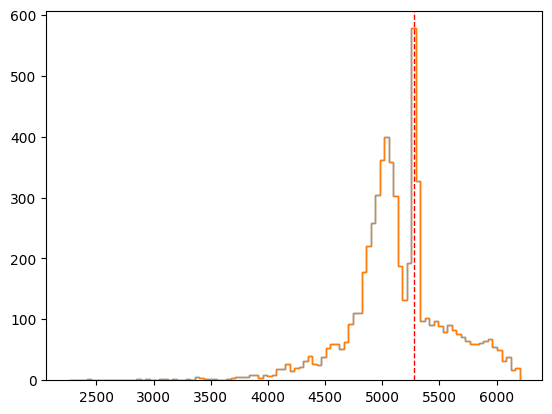

In [15]:
plt.hist(invariant_mass_array, bins=100,  histtype='step', label='Invariant Mass');
plt.axvline(5279, color='r', linestyle='dashed', linewidth=1);
values, bins, patches = plt.hist(invariant_mass_array, bins=100,  histtype='step', label='Invariant Mass');

### Fitting data

The following code shows how to fit a function to a dataset. The fit function is a sum of two functions, which can be extended to more complex functions. The output includes a chi2 calculation and plotting and saving of the resulting histogram.

In [7]:
bins_probpi

NameError: name 'bins_probpi' is not defined

[2978.0852271587464, 3010.3527272345673, 3042.620227310389, 3074.887727386211, 3107.1552274620317, 3139.4227275378535, 3171.6902276136743, 3203.957727689496, 3236.225227765318, 3268.4927278411387, 3300.7602279169605, 3333.027727992782, 3365.295228068603, 3397.562728144425, 3429.8302282202458, 3462.0977282960675, 3494.365228371889, 3526.63272844771, 3558.900228523532, 3591.167728599353, 3623.4352286751746, 3655.702728750996, 3687.970228826817, 3720.237728902639, 3752.50522897846, 3784.7727290542816, 3817.040229130103, 3849.3077292059243, 3881.575229281746, 3913.842729357567, 3946.1102294333887, 3978.37772950921, 4010.6452295850313, 4042.9127296608526, 4075.180229736674, 4107.447729812496, 4139.7152298883175, 4171.982729964138, 4204.250230039959, 4236.517730115782, 4268.785230191603, 4301.052730267424, 4333.320230343245, 4365.587730419067, 4397.855230494888, 4430.122730570709, 4462.390230646532, 4494.657730722352, 4526.925230798173, 4559.192730873996, 4591.460230949817, 4623.727731025638

NameError: name 'values_probpi' is not defined

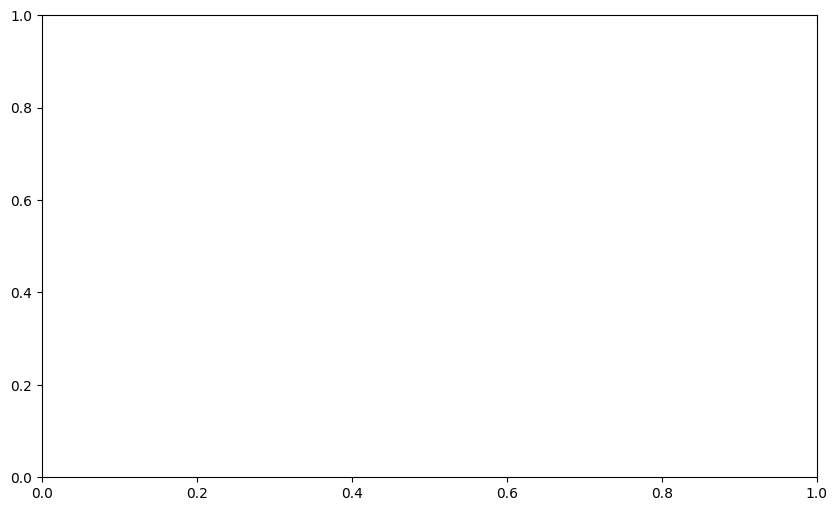

In [9]:
# decaying exponential function
def exponential(x, norm, decay):
    xoffset = 0 # this is a technical parameter, which can be used to move the position at which the function evaluates to "norm"
    return np.array( norm * np.exp(-(x-xoffset)/decay) )

# constant function
def constant(x, norm):
    return np.array( norm )

# fit function combining two individual functions
def fit_function(x, norm, normE, decay):
    return np.array( constant(x, norm) + exponential(x, normE, decay) )

def fit_data(bins, values, minX, maxX, p0):
    # determine bin centres
    bin_centres = [(a+b)/2 for a,b in zip(bins[0:-1],bins[1:]) ] # uses simultaneous loop over two arrays
    print(bin_centres)
    # reduce range to fit only part of curve
    bin_centres_red = [] 
    values_red = []
    for c,v in zip(bin_centres,values):
        if c < minX or c > maxX: continue
        bin_centres_red.append(c)
        values_red.append(v)
    print(bin_centres_red)
    # execute the fit with starting values as given in p0
    coeff_fit,cov_fit = curve_fit(fit_function,bin_centres_red,values_red,p0) # fit
    
    # evaluate chi2
    fit_vals = [fit_function(x,coeff_fit[0],coeff_fit[1],coeff_fit[2]) for x in bin_centres_red]
    chi2parts = np.array( ( np.divide( np.array(values_red) - np.array(fit_vals), np.sqrt( values_red ), 
                                      out = np.array(values_red), where = np.array(values_red) != 0 ) )**2 )
    chi2 = np.sum( chi2parts )
    
    return coeff_fit,cov_fit, bin_centres, bin_centres_red, chi2, len(chi2parts)

def print_results(coeff,cov,chi2,ndf):
    perr = np.sqrt(np.diag(cov)) # extract errors from covarianve matrix
    # output fit results
    print('Fit results with chi2/ndf', chi2,'/',ndf)
    parcount = 0
    for p,e in zip(coeff,perr):
        parcount += 1
        print('Par {:d}: {:f} +/- {:f}'.format(parcount,p,e))

def plot_results(a,bin_centres,bin_centres_red,values,coeff_fit,fname):
    # plot the data, this time as dots with error bars (sqrt(N) errors)
    a.errorbar(bin_centres,values,yerr=np.sqrt(values),linestyle='',marker='.',
               markerfacecolor='k',markeredgecolor='k',ecolor='k',label='Data')

    # plot the fit: create x values, then calculate the corresponding y values and plot
    x_fit = np.linspace(bin_centres_red[0],bin_centres_red[-1],100)
    y_fit = fit_function(x_fit,coeff_fit[0],coeff_fit[1],coeff_fit[2])
    a.plot(x_fit,y_fit,label='Fit',color='r',zorder=10) # zorder makes sure the fit line is on top

    # plot decoration
    a.legend()
    a.set_xlabel('$m_{inv}$ in MeV')
    a.set_ylabel('Entries per 2 MeV')
    plt.savefig(fname)


coeff_pT,cov_pT, bin_centres_pT, bin_centres_red_pT, chi2_pT, ndf_pT = fit_data( bins, values, 5100, 6500, [10,100,5000] )
# values_probpi, bins_probpi, patches_probpi = plotting_histograms_probability(particle=
#                                                                             None)
print_results(coeff_pT,cov_pT, chi2_pT, ndf_pT)

# plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plot_results(ax,bin_centres_pT,bin_centres_red_pT,values_probpi,coeff_pT,'fit_pT.pdf')

mean =  5282.511352023343
std =  28.614781570476122
chi2 =  181.9070796469794
ndf =  17


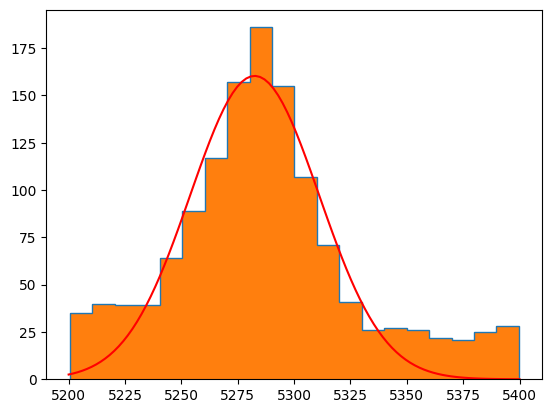

In [16]:
#get a sub invariant mass list that is between 5100 and 6500 MeV using numpy
invariant_mass_numpy = np.array(invariant_mass_array)

#remove indices where the invariant mass is not between 5100 and 6500 MeV
invariant_mass_numpy = np.where((invariant_mass_numpy > 5200) & (invariant_mass_numpy < 5400), invariant_mass_numpy, np.nan)
np.shape(invariant_mass_numpy)
plt.hist(invariant_mass_numpy, bins=20,  histtype='step', label='Invariant Mass');
#get bin centers and values
values, bins, patches = plt.hist(invariant_mass_numpy, bins=20)

#fit a gaussian to the dataset 
def gaussian(x, norm, mean, sigma):
    return np.array( norm * np.exp( -0.5 * ( (x-mean)/sigma )**2 ) )


def fit_func(x, norm, mean, sigma):
    return np.array( gaussian(x, norm, mean, sigma) )

def get_bins(data, values):
    
    bin_centers = [(a+b)/2 for a,b in zip(data[0:-1],data[1:]) ]

    return bin_centers

#fit using curve_fit
popt, pcov = curve_fit(fit_func, get_bins(bins, values), values, p0=[100, 5300, 10])

#plot the data
x_data = np.linspace(5200, 5400, 100)
y_data = gaussian(x_data, popt[0], popt[1], popt[2])

plt.plot(x_data, y_data, 'r-', label='fit')

#find the mean and standard deviation of the gaussian fit
mean = popt[1]
std = popt[2]

print('mean = ', mean)
print('std = ', std)


chi2 = np.sum(((values - gaussian(get_bins(bins, values), popt[0], popt[1], popt[2]))/np.sqrt(values))**2)
ndf = len(values) - 3

print('chi2 = ', chi2)
print('ndf = ', ndf)

### Manipulation of 2D histograms

The following is an example code to demonstrate manipulation of the content of 2D histograms. It first produces two dummy histograms before working out the bin centres, subtracting the histogram contents, and finally plotting. The subtraction bit can of course be replaced by more complex operations as well.

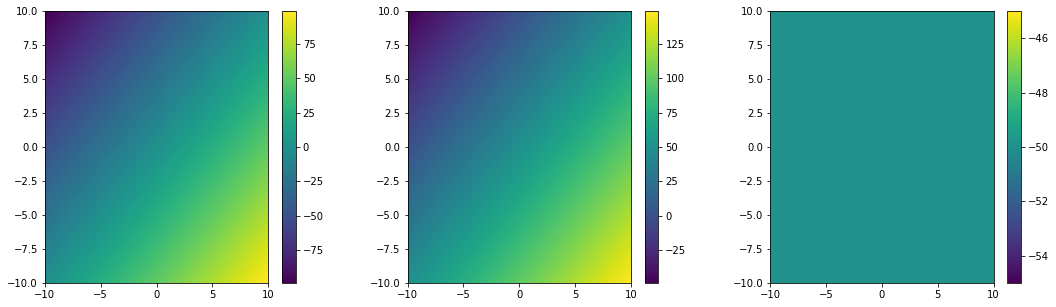

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
fig.subplots_adjust(wspace=0.3) # increase horizontal space between plots

### ignore this bit and replace by however you produce your two 2D histograms to be subtracted ###
xvalues = []
yvalues = []
weights1 = []
weights2 = []
for x in range(100):
    for y in range(100):
        xvalues.append(-10+x/5.+0.1) # bin centre for x
        yvalues.append(-10+y/5.+0.1) # bin centre for y
        weights1.append((x-y))       # weights for histo1, this would be filled automatically
        weights2.append((x-y)+50)    # weights for histo2
h2d1 = ax[0].hist2d(xvalues,yvalues,weights=weights1,bins = [100,100], range = [[-10,10],[-10,10]])        
h2d2 = ax[1].hist2d(xvalues,yvalues,weights=weights2,bins = [100,100], range = [[-10,10],[-10,10]])
### end ignoring here :) ###

# first calculate the bin centres from the bin boundaries of the hist2d object
xcentres = []
ycentres = []
for a,b in zip(h2d1[1][0:-1],h2d1[1][1:]):
    for c,d in zip(h2d1[2][0:-1],h2d1[2][1:]):
        xcentres.append( (a+b)/2 )
        ycentres.append( (c+d)/2 )

# now extract the weights, that is the bin contents
w1 = (np.array(h2d1[0])).flatten()
w2 = (np.array(h2d2[0])).flatten()
wsub = np.subtract(w1,w2) # subtract bin content of two histograms

# produce the new histogram
h2d3 = ax[2].hist2d(xcentres,ycentres,weights=wsub, bins = [h2d1[1],h2d1[2]]) # recycle the binning from above

# plot the lot
fig.colorbar(h2d1[3],ax=ax[0]) # let's add the colour scale for histo 1
fig.colorbar(h2d2[3],ax=ax[1]) # let's add the colour scale for histo 2
fig.colorbar(h2d3[3],ax=ax[2]) # let's add the colour scale for histo 3